In [2]:
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

In [32]:
logs = pd.read_excel('E:\\vscode\\data.xlsx')
users = pd.read_excel('E:\\vscode\\data.xlsx', sheet_name='users')
logs.dropna(subset='Дата', inplace=True)

# Расчет когорт

In [33]:
df = logs[logs['Тип события'] == 'Покупка']
reg = logs[['ID', 'Дата']].sort_values(by = 'Дата').drop_duplicates(subset = 'ID')

In [46]:
df['reg_date'] = logs.groupby('ID')['Дата'].transform('min')

C:\Users\nikit\AppData\Local\Temp\ipykernel_18532\3230290376.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['reg_date'] = logs.groupby('ID')['Дата'].transform('min')


,ID,Дата,Тип события,Сумма покупки,reg_date
2,256,2019-01-04,Покупка,1698.0,2019-01-02
6,268,2019-01-06,Покупка,1098.0,2019-01-01
18,351,2019-01-02,Покупка,827.0,2019-01-01
20,351,2019-01-07,Покупка,616.0,2019-01-01
27,335,2019-01-06,Покупка,642.0,2019-01-02
...,...,...,...,...,...
35752,185,2019-03-02,Покупка,1309.0,2019-01-02
35754,185,2019-03-04,Покупка,809.0,2019-01-02
35756,132,2019-03-01,Покупка,1188.0,2019-01-02
35770,31,2019-03-04,Покупка,1279.0,2019-01-03


In [39]:
mt = df.groupby([pd.Grouper(key = 'reg_date', freq = 'W'), pd.Grouper(key = 'Дата', freq = 'W')]).nunique().reset_index()
mt['period_number'] = (mt['Дата'] - mt['reg_date'])

In [7]:
cohort_pivot = mt.pivot_table(index='reg_date', columns= ['period_number'], values='ID')

In [8]:
cohort_pivot.insert(0, 'cohort_size', reg.groupby(pd.Grouper(key = 'Дата', freq = 'W'))['ID'].count())

In [9]:
cohort_pivot


period_number,cohort_size,0 days 00:00:00,7 days 00:00:00,14 days 00:00:00,21 days 00:00:00,28 days 00:00:00,35 days 00:00:00,42 days 00:00:00,49 days 00:00:00,56 days 00:00:00,63 days 00:00:00
reg_date,,,,,,,,,,,
2019-01-06,396,208.0,106.0,54.0,29.0,20.0,22.0,18.0,12.0,10.0,6.0
2019-01-13,467,273.0,137.0,58.0,36.0,33.0,25.0,27.0,13.0,1.0,NaN
2019-01-20,337,182.0,88.0,40.0,27.0,21.0,18.0,18.0,2.0,NaN,NaN
2019-01-27,352,222.0,88.0,41.0,31.0,26.0,22.0,6.0,NaN,NaN,NaN
2019-02-03,500,271.0,127.0,54.0,51.0,34.0,8.0,NaN,NaN,NaN,NaN
2019-02-10,549,286.0,147.0,71.0,53.0,9.0,NaN,NaN,NaN,NaN,NaN
2019-02-17,294,174.0,79.0,40.0,14.0,NaN,NaN,NaN,NaN,NaN,NaN
2019-02-24,409,228.0,101.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-03-03,325,172.0,39.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Построение тепловой карты

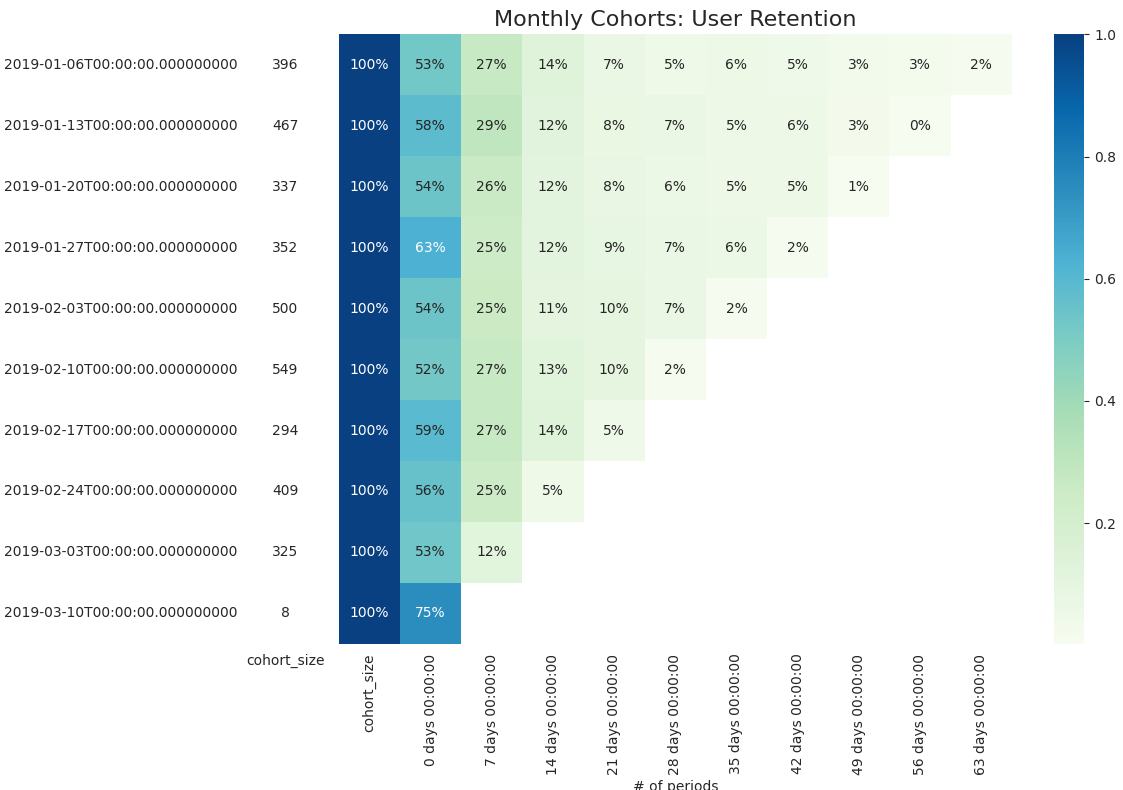

In [10]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)

with sns.axes_style("white"):
    fig, ax = plt.subplots(1, 2, figsize=(12, 8), sharey=True, gridspec_kw={'width_ratios': [1, 11]})
    
    # retention matrix
    sns.heatmap(retention_matrix, 
                mask=retention_matrix.isnull(), 
                annot=True, 
                fmt='.0%', 
                cmap='GnBu', 
                ax=ax[1])
    ax[1].set_title('Monthly Cohorts: User Retention', fontsize=16)
    ax[1].set(xlabel='# of periods',
              ylabel='')

    # cohort size
    cohort_size_df = pd.DataFrame(cohort_size).rename(columns={0: 'cohort_size'})
    white_cmap = mcolors.ListedColormap(['white'])
    sns.heatmap(cohort_size_df, 
                annot=True, 
                cbar=False, 
                fmt='g', 
                cmap=white_cmap, 
                ax=ax[0])

    fig.tight_layout()

# Количество привлечённых клиентов по неделям и источникам привлечения										


In [61]:
conv = users.merge(reg, on = 'ID', how = 'right').groupby([pd.Grouper(key = 'Дата', freq = 'W'), 'Источник', 'Регион']).nunique().reset_index()
conv_pivot = conv.pivot_table(columns = 'Дата', index = 'Источник', values = 'ID', aggfunc= sum, margins= True)
conv_pivot

C:\Users\nikit\AppData\Local\Temp\ipykernel_18532\3912328621.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  conv_pivot = conv.pivot_table(columns = 'Дата', index = 'Источник', values = 'ID', aggfunc= sum, margins= True)
C:\Users\nikit\AppData\Local\Temp\ipykernel_18532\3912328621.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  conv_pivot = conv.pivot_table(columns = 'Дата', index = 'Источник', values = 'ID', aggfunc= sum, margins= True)
C:\Users\nikit\AppData\Local\Temp\ipykernel_18532\3912328621.py:2: FutureWarning: The provided callable <built-in function sum> is currently using DataFrameGroupBy.sum. I

Дата,2019-01-06 00:00:00,2019-01-13 00:00:00,2019-01-20 00:00:00,2019-01-27 00:00:00,2019-02-03 00:00:00,2019-02-10 00:00:00,2019-02-17 00:00:00,2019-02-24 00:00:00,2019-03-03 00:00:00,2019-03-10 00:00:00,All
Источник,,,,,,,,,,,
Seo-продвижение сайта,107,127,80,102,120,160,80,105,70,1,952
Smm,90,121,84,81,136,135,89,109,92,1,938
Контекстная реклама,102,114,94,90,138,133,52,90,84,3,900
Рекламное объявление,97,105,79,79,106,121,73,105,79,3,847
All,396,467,337,352,500,549,294,409,325,8,3637


# Стоимость привлечения клиентов по неделям и источникам привлечения										


In [60]:
price = users.merge(reg, on = 'ID', how = 'right').groupby([pd.Grouper(key = 'Дата', freq = 'W'), 'Источник', 'Регион'])['Стоимость привлечения'].sum().reset_index()
price_pivot = price.pivot_table(columns = 'Дата', index = 'Источник', values = 'Стоимость привлечения', aggfunc= {'Стоимость привлечения': "sum"}, margins = True)
price_pivot


Дата,2019-01-06 00:00:00,2019-01-13 00:00:00,2019-01-20 00:00:00,2019-01-27 00:00:00,2019-02-03 00:00:00,2019-02-10 00:00:00,2019-02-17 00:00:00,2019-02-24 00:00:00,2019-03-03 00:00:00,2019-03-10 00:00:00,All
Источник,,,,,,,,,,,
Seo-продвижение сайта,49245,57761,35602,46185,56576,71687,37561,47623,31434,593,434267
Smm,42709,55650,39803,37157,62050,61800,40985,48793,41889,600,431436
Контекстная реклама,48295,51911,44198,41741,63822,60313,23447,40742,37700,1495,413664
Рекламное объявление,43488,48435,36506,36004,50257,56670,33939,48395,37657,1348,392699
All,183737,213757,156109,161087,232705,250470,135932,185553,148680,4036,1672066


# Доход, полученный с привлечённых клиентов по неделям и источникам привлечения										


In [58]:
rev = users.merge(df, how = 'right', on = 'ID').groupby([pd.Grouper(key = 'reg_date', freq = 'W'), 'Регион', 'Источник'])['Сумма покупки'].sum().reset_index()
rt = pd.pivot_table(rev, values = 'Сумма покупки', columns = 'reg_date', index = 'Источник', margins = True, aggfunc={'Сумма покупки': "sum"})
rt

reg_date,2019-01-06 00:00:00,2019-01-13 00:00:00,2019-01-20 00:00:00,2019-01-27 00:00:00,2019-02-03 00:00:00,2019-02-10 00:00:00,2019-02-17 00:00:00,2019-02-24 00:00:00,2019-03-03 00:00:00,2019-03-10 00:00:00,All
Источник,,,,,,,,,,,
Seo-продвижение сайта,177183.0,297616.0,146678.0,220215.0,230708.0,259851.0,175549.0,154994.0,75243.0,1236.0,1739273.0
Smm,145723.0,149820.0,112884.0,105607.0,177948.0,187863.0,135010.0,87400.0,67326.0,411.0,1169992.0
Контекстная реклама,238757.0,188418.0,181123.0,153312.0,260069.0,244820.0,84446.0,123972.0,87187.0,2796.0,1564900.0
Рекламное объявление,151479.0,231061.0,139057.0,132432.0,163171.0,192222.0,82847.0,149528.0,61440.0,1990.0,1305227.0
All,713142.0,866915.0,579742.0,611566.0,831896.0,884756.0,477852.0,515894.0,291196.0,6433.0,5779392.0


# Основные показатели юнит-экономики по неделям										


In [96]:
logs['reg_date'] = logs.groupby('ID')['Дата'].transform('min')
unique_users = logs.groupby(pd.Grouper(key = 'Дата', freq = "W"))['ID'].nunique()
total_orders = logs[logs['Тип события'] == 'Покупка'].groupby(pd.Grouper(key = 'Дата', freq = 'W'))['ID'].count()
unique_customers = logs[logs['Тип события'] == 'Покупка'].groupby(pd.Grouper(key = 'Дата', freq = 'W'))['ID'].nunique()
revenue = logs[logs['Тип события'] == 'Покупка'].groupby(pd.Grouper(key = 'Дата', freq = 'W'))['Сумма покупки'].sum()
acquisitions_costs = users.merge(reg, on = 'ID', how = 'right').groupby([pd.Grouper(key = 'Дата', freq = 'W')])['Стоимость привлечения'].sum()

In [94]:
unit_economic_by_week = pd.DataFrame(index = mt.reg_date.unique())
unit_economic_by_week ['unique_users'] = unique_users
unit_economic_by_week ['total_orders'] = total_orders
unit_economic_by_week ['unique_customers'] = unique_customers
unit_economic_by_week ['orders_per_customer'] = round(total_orders / unique_customers, 2)
unit_economic_by_week ['coeff_conversion'] = round(unique_customers / unique_users, 2)
unit_economic_by_week ['revenue'] = revenue
unit_economic_by_week ['ARPC'] = round(revenue / total_orders, 2)
unit_economic_by_week ['ARPPU'] = round(revenue / unique_customers, 2)
unit_economic_by_week ['acquisition_costs'] = acquisitions_costs
unit_economic_by_week ['income'] = revenue - acquisition_costs
unit_economic_by_week 


,unique_users,total_orders,unique_customers,orders_per_customer,coeff_conversion,revenue,ARPC,ARPPU,acquisition_costs,income
2019-01-06,396,316,208,1.52,0.53,309677.0,979.99,1488.83,183737,125940.0
2019-01-13,735,555,379,1.46,0.52,548370.0,988.05,1446.89,213757,334613.0
2019-01-20,737,559,373,1.50,0.51,541833.0,969.29,1452.64,156109,385724.0
2019-01-27,730,568,397,1.43,0.54,544032.0,957.80,1370.36,161087,382945.0
2019-02-03,913,649,455,1.43,0.50,640819.0,987.39,1408.39,232705,408114.0
2019-02-10,1086,829,536,1.55,0.49,815951.0,984.26,1522.30,250470,565481.0
2019-02-17,923,760,470,1.62,0.51,752573.0,990.23,1601.22,135932,616641.0
2019-02-24,958,797,512,1.56,0.53,785523.0,985.60,1534.22,185553,599970.0
2019-03-03,930,724,463,1.56,0.50,716999.0,990.33,1548.59,148680,568319.0
2019-03-10,372,121,112,1.08,0.30,123615.0,1021.61,1103.71,4036,119579.0


# Показатели, характеризующие эффективность привлечения по когортам привлечения														


In [132]:
logs['reg_date'] = logs.groupby('ID')['Дата'].transform('min')
logs['activity'] = logs.groupby('ID').transform('size')
attr_users = logs.groupby(pd.Grouper(key = 'reg_date', freq = "W"))['ID'].nunique()
attr_customers = logs[logs["Тип события"] == "Покупка"].groupby(pd.Grouper(key = 'reg_date', freq = "W"))['ID'].nunique()
retention = logs[logs['activity'] > 1].groupby(pd.Grouper(key = 'reg_date', freq ='W'))['ID'].nunique()
rr = round(retention / attr_users, 2)
atrr_cost = logs.merge(users, on = 'ID', how = 'right').drop_duplicates('ID').groupby([pd.Grouper(key = 'reg_date', freq = 'W')])['Стоимость привлечения'].sum()
revenue_cohort = logs.groupby(pd.Grouper(key = 'reg_date', freq = 'W'))['Сумма покупки'].sum()

In [141]:
unit_economic_per_cohort = pd.DataFrame(index = mt.reg_date.unique())
unit_economic_per_cohort['atrr_users'] = attr_users
unit_economic_per_cohort['atrr_customers'] = attr_customers
unit_economic_per_cohort['retention'] = retention
unit_economic_per_cohort['churn'] = attr_users - retention
unit_economic_per_cohort['RR'] = round(retention / attr_users, 2)
unit_economic_per_cohort['CR'] = 1 - rr
unit_economic_per_cohort['atrr_cost'] = atrr_cost
unit_economic_per_cohort['CPA'] = round(atrr_cost / attr_users, 2)
unit_economic_per_cohort['conversion'] = round(attr_customers / attr_users, 2)
unit_economic_per_cohort['CPC'] = round(atrr_cost / attr_customers, 2)
unit_economic_per_cohort['revenue'] = revenue_cohort
unit_economic_per_cohort['ARPU'] = round(revenue_cohort / attr_users, 2)
unit_economic_per_cohort['ARPPU'] = round(revenue_cohort / attr_customers, 2)
unit_economic_per_cohort['ROI'] = round((revenue_cohort - atrr_cost) / atrr_cost, 4) * 100
unit_economic_per_cohort

,atrr_users,atrr_customers,retention,churn,RR,CR,atrr_cost,CPA,conversion,CPC,revenue,ARPU,ARPPU,ROI
2019-01-06,396,270,375,21,0.95,0.05,183737,463.98,0.68,680.51,713142.0,1800.86,2641.27,288.13
2019-01-13,467,343,441,26,0.94,0.06,213757,457.72,0.73,623.20,866915.0,1856.35,2527.45,305.56
2019-01-20,337,233,314,23,0.93,0.07,156109,463.23,0.69,670.00,579742.0,1720.30,2488.16,271.37
2019-01-27,352,266,341,11,0.97,0.03,161087,457.63,0.76,605.59,611566.0,1737.40,2299.12,279.65
2019-02-03,500,346,474,26,0.95,0.05,232705,465.41,0.69,672.56,831896.0,1663.79,2404.32,257.49
2019-02-10,549,366,515,34,0.94,0.06,250470,456.23,0.67,684.34,884756.0,1611.58,2417.37,253.24
2019-02-17,294,205,279,15,0.95,0.05,135932,462.35,0.70,663.08,477852.0,1625.35,2330.99,251.54
2019-02-24,409,275,380,29,0.93,0.07,185553,453.67,0.67,674.74,515894.0,1261.35,1875.98,178.03
2019-03-03,325,187,294,31,0.90,0.10,148680,457.48,0.58,795.08,291196.0,895.99,1557.20,95.85
2019-03-10,8,6,6,2,0.75,0.25,4036,504.50,0.75,672.67,6433.0,804.12,1072.17,59.39
